# Importing the libraries for simulation ###

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import os, sys
parent_dir = os.path.abspath(os.pardir)
libpath = os.path.join(parent_dir, 'source_code')
if not libpath in sys.path:
    sys.path.insert(0, libpath)

# Plotting the beam profile at main shutter exit  
simulated by McStas using [hb3a_Fahima.instr](https://raw.githubusercontent.com/Fahima-Islam/HB3A_simulation/master/source_code/hb3a_Fahima.instr)

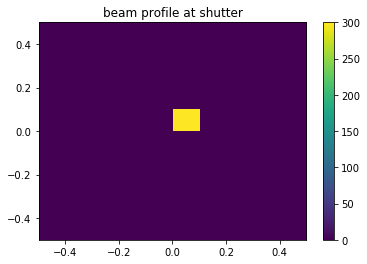

In [2]:
beam_profile_shutter = np.loadtxt('profile_at_main_shutter_exit_ncounts_1e7.dat')
plt.figure()
plt.title('beam profile at shutter')
plt.hist2d(beam_profile_shutter[:,0], beam_profile_shutter[:,1])
plt.colorbar()
plt.show()

# Plotting the wavelength distribution at main shutter exit 
simulated by McStas using [hb3a_Fahima.instr](https://raw.githubusercontent.com/Fahima-Islam/HB3A_simulation/master/source_code/hb3a_Fahima.instr)

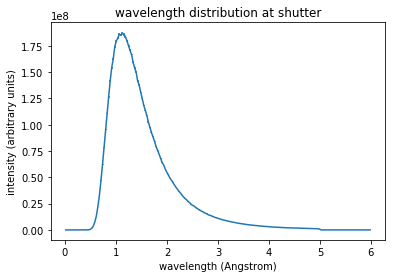

In [30]:
wavelength_distribution_shutter = np.loadtxt('wavelength_at_main_shutter_exit_ncounts_1e7.dat')
plt.figure()
plt.title('wavelength distribution at shutter')
plt.errorbar(wavelength_distribution_shutter[:,0], wavelength_distribution_shutter[:,1], 
             wavelength_distribution_shutter[:,2])
plt.ylabel('intensity (arbitrary units)')
plt.xlabel('wavelength (Angstrom)')
plt.show()

# Plotting the wavelength distribution at sample 
simulated by McStas using [hb3a_Fahima.instr](https://raw.githubusercontent.com/Fahima-Islam/HB3A_simulation/master/source_code/hb3a_Fahima.instr)

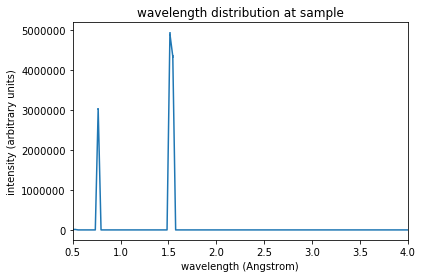

In [26]:
wavelength_distribution_sample = np.loadtxt('wavelength_at_sample_ncounts_1e7.dat')
plt.figure()
plt.title('wavelength distribution at sample')
plt.errorbar(wavelength_distribution_sample[:,0], wavelength_distribution_sample[:,1], 
             wavelength_distribution_sample[:,2])
plt.ylabel('intensity (arbitrary units)')
plt.xlabel('wavelength (Angstrom)')
plt.xlim (0.5,4)
plt.show()

# Transition from McStas to MCViNE
Converting McStas simulated data of neutrons at sample position to MCViNE data format to perform the simulation from the sample. The source code that we are using here is [COnversion_MCSTAStoMCVINE_file](https://raw.githubusercontent.com/Fahima-Islam/HB3A_simulation/master/source_code/COnversion_MCSTAStoMCVINE_file.py)

In [7]:
from COnversion_MCSTAStoMCVINE_file import mcstas2mcvine

mcstas_file_name = 'neutrons_at_sample_ncounts_1e7.dat'
mcvine_file_name= 'neutrons_at_sample_HB3A_ncounts_1e7_mcvine.dat'
Mcstas_file_path=os.path.join(parent_dir, 'results/{mcstas_file_name}'.format(mcstas_file_name=mcstas_file_name))
McVine_file_path=os.path.join(parent_dir, 'results/{mcvine_file_name}'.format(mcvine_file_name=mcvine_file_name))

mcstas2mcvine(Mcstas_file_path, McVine_file_path)

# Verifying the takeoff angle of the monochromator after converting the simulated data from McStas to MCViNE and finding the optimum position of the collimator to place in the simulation
note that in Mantid instrument definition, the clock wise direction is considered as positive, but the software that we are using to simulate the collimator geometry, the anti-clockwise direction is considered as positive, so we are adjusting accordingly. The source code is [neutrons2lambda](https://raw.githubusercontent.com/Fahima-Islam/HB3A_simulation/master/source_code/neutrons2lambda.py)  


In [37]:
from neutrons2lambda import process , convert2histogram

neutrons= process(McVine_file_path, neutron_properties_flag= True)
vx = neutrons[:,3]
vy = neutrons[:,4]
vz= neutrons[:,5]
v = (vx*vx + vy*vy +vz*vz)**.5 ## calculating velocity vector
cos2theta = vz/v # calculating the scattering angle of the monochromator
theta = np.rad2deg(np.arccos(cos2theta))
print ('take off angle of the monochromator: ', theta[0])
collimator_angle = 270+theta

('take off angle of the monochromator: ', 96.51532742653697)


# Collimator geometry creation ###

The source code is [create_collimator_geometry_HB3A](https://raw.githubusercontent.com/Fahima-Islam/HB3A_simulation/master/source_code/create_collimator_geometry_HB3A.py) (written by Fahima Islam (islamfff@ornl.gov)).
If you want to produce the cad file then change scad_flag to "TRUE" otherwise "FALSE"

In [38]:
scad_FLAG = True

COLLIMATOR_GEOMETRY_FILE_NAME = 'coll_geometry_HB3A'

from create_collimator_geometry_HB3A import create as create_collimator
create_collimator(coll_front_end_from_center=168, max_coll_len=298, detector_width= 126. , 
                  detector_height = 340.,
                  min_channel_wall_thickness=2.0, min_channel_size=3.,
                  detector_angles=[collimator_angle[0],-135],multiple_collimator=False, 
                  horizontal_number_channels=15,
                  vertical_number_channels=3,
                  collimator_Nosupport=True, scad_flag=scad_FLAG,
                  outputfile=COLLIMATOR_GEOMETRY_FILE_NAME)

('vertical number of channels: ', 3.0)
('horizontal number of channels: ', 15)


# Viewing the 3D collimator geometry ###

In [3]:
import cad as cad
cad.xmlToOpenScad(filename=COLLIMATOR_GEOMETRY_FILE_NAME+'.xml')
# !vglrun openscad {COLLIMATOR_GEOMETRY_FILE_NAME+'.scad'}
from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML('<h3>3D collimator</h3>'))
Image(url= "https://raw.githubusercontent.com/Fahima-Islam/HB3A_simulation/master/results/HB3A_collimator.png")

# Creating the scattering kernel of plastic collimator
using the source code[scattering_kernal_program](https://raw.githubusercontent.com/Fahima-Islam/HB3A_simulation/master/source_code/scattering_kernal_program.py)(written by Fahima Islam (islamfff@ornl.gov))

In [13]:
scaterer_type_name = 'plastic_collimator'
path_tosave_collimator_geometry = os.path.join(parent_dir, 'results')
collimator_geo_file_Name = COLLIMATOR_GEOMETRY_FILE_NAME
collimator_geo_file = os.path.join (path_tosave_collimator_geometry, collimator_geo_file_Name)

import scattering_kernal_program as skp
kernel_type = 'inelastic'

S_Q_E = "exp(-2.07*Q*Q/30.)"
Q_min = "0./angstrom"
Q_max = "15./angstrom"
Energy_transfer = '-2.07*Q*Q'
absorption_factor=0
scattering_factor=1
transmission_factor=3
path_toSave_scateringKernel_file = os.path.join(parent_dir, 'results')

skp.makeSKXML(kernel_type,path_toSave_scateringKernel_file, scaterer_type_name,
              absorption=absorption_factor,scattering=scattering_factor,transmission=transmission_factor,
              E=Energy_transfer, S_Q_E=S_Q_E, Qmin=Q_min, Qmax=Q_max) 

# crystal structural information for collimator's material ### 

In [7]:
!cat {parent_dir+'/materials/H.xyz'}

2
1.67 0 0   0 1.67 0   0 0 1.67
H 0  0  0
H 0.5 0.5 0.5






# Combining the geometry,scattering kernel, material's crystal structure for plastic collimator in order to run the simulation
using the source code [sampleassembly_program](https://raw.githubusercontent.com/Fahima-Islam/HB3A_simulation/master/source_code/sampleassembly_program.py) (written by Fahima Islam (islamfff@ornl.gov))

In [14]:
from sampleassembly_program import makeSAXML

sample_assembly_fileName = 'collimator'
shape_name = 'shapeCollimator'
structure_file_type ='xyz'
sample_Formula = 'H'
input_xyz_file_path = os.path.join(parent_dir, 'materials/H.xyz')
path_toSave_scateringnel_file = os.path.join(parent_dir, 'results')
scatterer = {
            (scaterer_type_name,shape_name , collimator_geo_file, sample_Formula ,input_xyz_file_path, structure_file_type)
             
            }

makeSAXML(sample_assembly_fileName, path_toSave_scateringKernel_file, scatterer)

# Creating the detector for HB3A
using the source code [detector_geometry_program](https://raw.githubusercontent.com/Fahima-Islam/HB3A_simulation/master/source_code/detector_geometry_program.py) (written by Fahima Islam (islamfff@ornl.gov))

In [16]:
from detector_geometry_program import makeDetXML as detGeo

path_ToSave_detector_file= '.'
detector_file_name = 'HB3A_virtual.xml'
name_of_instrument = 'HB3A'
source_to_sample_distance = 7
det_r_position = 0
det_t_position = 0
det_p_position = 0
det_rot_x =0 
det_rot_y = 96
det_rot_z = 0
sampleTodetector_z = 0.3
number_pixels_x = 256
number_pixels_y = 256
det_xwidth = 0.5
det_yheight = 0.5
detGeo(path_ToSave_detector_file, detector_file_name, name_of_instrument, source_to_sample_distance,
       det_r_position, det_t_position, det_p_position, det_rot_x, det_rot_y, det_rot_z,sampleTodetector_z,
       number_pixels_x, number_pixels_y, det_xwidth, det_yheight)

# Simulating the diffraction pattern for plastic collimator
using the source code [optimizer](https://raw.githubusercontent.com/Fahima-Islam/HB3A_simulation/master/source_code/optimizer.py) (written by Fahima Islam (islamfff@ornl.gov))

('detector_angle: ', 96)
(256, 256)


/home/fi0/anaconda2/envs/mcvine/lib/python2.7/site-packages/mcvine/run_script.py:125: UserWarning: Developer: <mccomposite.mccompositebp.CompositeNeutronScatterer object at 0x7fb2d81fc6d8> does not implement method "create_pps"
  warnings.warn('Developer: %s does not implement method "create_pps"' % comp)


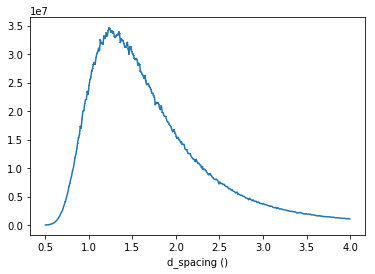

In [23]:
import optimizer as opt
coll=opt.Optimizer()

coll.parameters(    source_file = mcvine_file_name,
                    beam_path='.',
                    sample_path = '.',
                    nexus_path = '.',
                    result_path='.',
                    param_names = ['coll_front_end_from_center', 'max_coll_len'],
                    template =None,
                    instrument_definition_file = detector_file_name,
                    nodes=20,
                    sampleassembly_fileName = sample_assembly_fileName,
                    path_tosave_collimator_geometry = collimator_geo_file,
                    collimator_detector_width = 126,
                    collimator_detector_height = 340,
                    min_channel_wall_thickness = 2,
                    min_channel_size = 3.,
                    horizontal_number_channels=15,
                    vertical_number_channels=3,
                    coll_front_end_from_center =500.,
                    multiple_collimator = False,
                    collimator_Nosupport = True,
                    scad_flag = False,
                    ncount=1e8, 
                    sourceTosample_x = 0.0,
                    sourceTosample_y = 0.0, 
                    sourceTosample_z = 0.0,
                    angleMons = [96, 135] ,
                    collimator_angles= collimator_angle[0],
                    max_coll_len = 298,
                    wall_size =2.,
                    sampleTodetector_z=[sampleTodetector_z, sampleTodetector_z], 
                    detector_width=[det_xwidth,det_xwidth], detector_height=[det_yheight, det_yheight],
                    number_pixels_in_height=[number_pixels_x, number_pixels_x],
                    number_pixels_in_width=[number_pixels_y, number_pixels_y], 
                    number_of_box_in_height=[1,1],
                    number_of_box_in_width=[1,1], masking = False,
                    binning=[0.5, 0.01, 4.],number_of_detectors= 1
                    )

instr = os.path.join(parent_dir, 'source_code/myinstrument_multipleDetectors.py')
wavelength_collimator = coll.diffraction_pattern_calculation (params=[500, 298], 
                                                              instr=instr)